In [20]:
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

In [21]:
# load pretrained models
load_pretrained_models = False
# number of epochs of training
n_epochs = 100
# size of the batches
batch_size = 16
# name of the dataset
dataset_name = "../input/places365/val_256/train_samples"
test_dataset_name = "../input/places365/val_256/test_samples"

# adam: learning rate
lr = 0.00008
# adam: decay of first order momentum of gradient
b1 = 0.5
# adam: decay of first order momentum of gradient
b2 = 0.999
# number of cpu threads to use during batch generation
n_cpu = 4
# dimensionality of the latent space
latent_dim = 100
# size of each image dimension
img_size = 128
# size of random mask
mask_size = 64
# number of image channels
channels = 3
# interval between image sampling
sample_interval = 500

cuda = True if torch.cuda.is_available() else False
os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

# Calculate output dims of image discriminator (PatchGAN)
patch_h, patch_w = int(mask_size / 2 ** 3), int(mask_size / 2 ** 3)
patch = (1, patch_h, patch_w)

In [22]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, img_size=128, mask_size=64, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.img_size = img_size
        self.mask_size = mask_size
        self.mode = mode
        self.files = sorted(glob.glob("%s/*.jpg" % root))
        self.files = self.files[:-4000] if mode == "train" else self.files[-4000:]

    def apply_random_mask(self, img):
        """Randomly masks image"""
        y1, x1 = np.random.randint(0, self.img_size - self.mask_size, 2)
        y2, x2 = y1 + self.mask_size, x1 + self.mask_size
        masked_part = img[:, y1:y2, x1:x2]
        masked_img = img.clone()
        masked_img[:, y1:y2, x1:x2] = 1

        return masked_img, masked_part

    def apply_center_mask(self, img):
        """Mask center part of image"""
        # Get upper-left pixel coordinate
        i = (self.img_size - self.mask_size) // 2
        masked_img = img.clone()
        masked_img[:, i : i + self.mask_size, i : i + self.mask_size] = 1

        return masked_img, i

    def __getitem__(self, index):

        img = Image.open(self.files[index % len(self.files)])
        img = self.transform(img)
        if self.mode == "train":
            # For training data perform random mask
            masked_img, aux = self.apply_random_mask(img)
        else:
            # For test data mask the center of the image
            masked_img, aux = self.apply_center_mask(img)

        return img, masked_img, aux

    def __len__(self):
        return len(self.files)

In [23]:
class GrayscaleTo3Channels(object):
    def __init__(self):
        pass

    def __call__(self, img):
        # If the image is grayscale ('L'), convert to 3 channels (RGB)
        if img.mode == 'L':
            img = img.convert('RGB')
        return img



transforms_ = [
    transforms.Resize((img_size, img_size), Image.BICUBIC),
    GrayscaleTo3Channels(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]
dataloader = DataLoader(
    ImageDataset(dataset_name, transforms_=transforms_),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)
test_dataloader = DataLoader(
    ImageDataset(test_dataset_name, transforms_=transforms_, mode="val"),
    batch_size=12,
    shuffle=False,
    num_workers=1,
)

In [24]:
img, masked_imgs, aux = next(iter(dataloader))
img.shape, masked_imgs.shape, aux.shape

(torch.Size([16, 3, 128, 128]),
 torch.Size([16, 3, 128, 128]),
 torch.Size([16, 3, 64, 64]))

CONTEXT ENCODER GAN

![image.png](attachment:d08d4185-![](http://)04d3-47f0-ab3e-197700c2ad25.png)
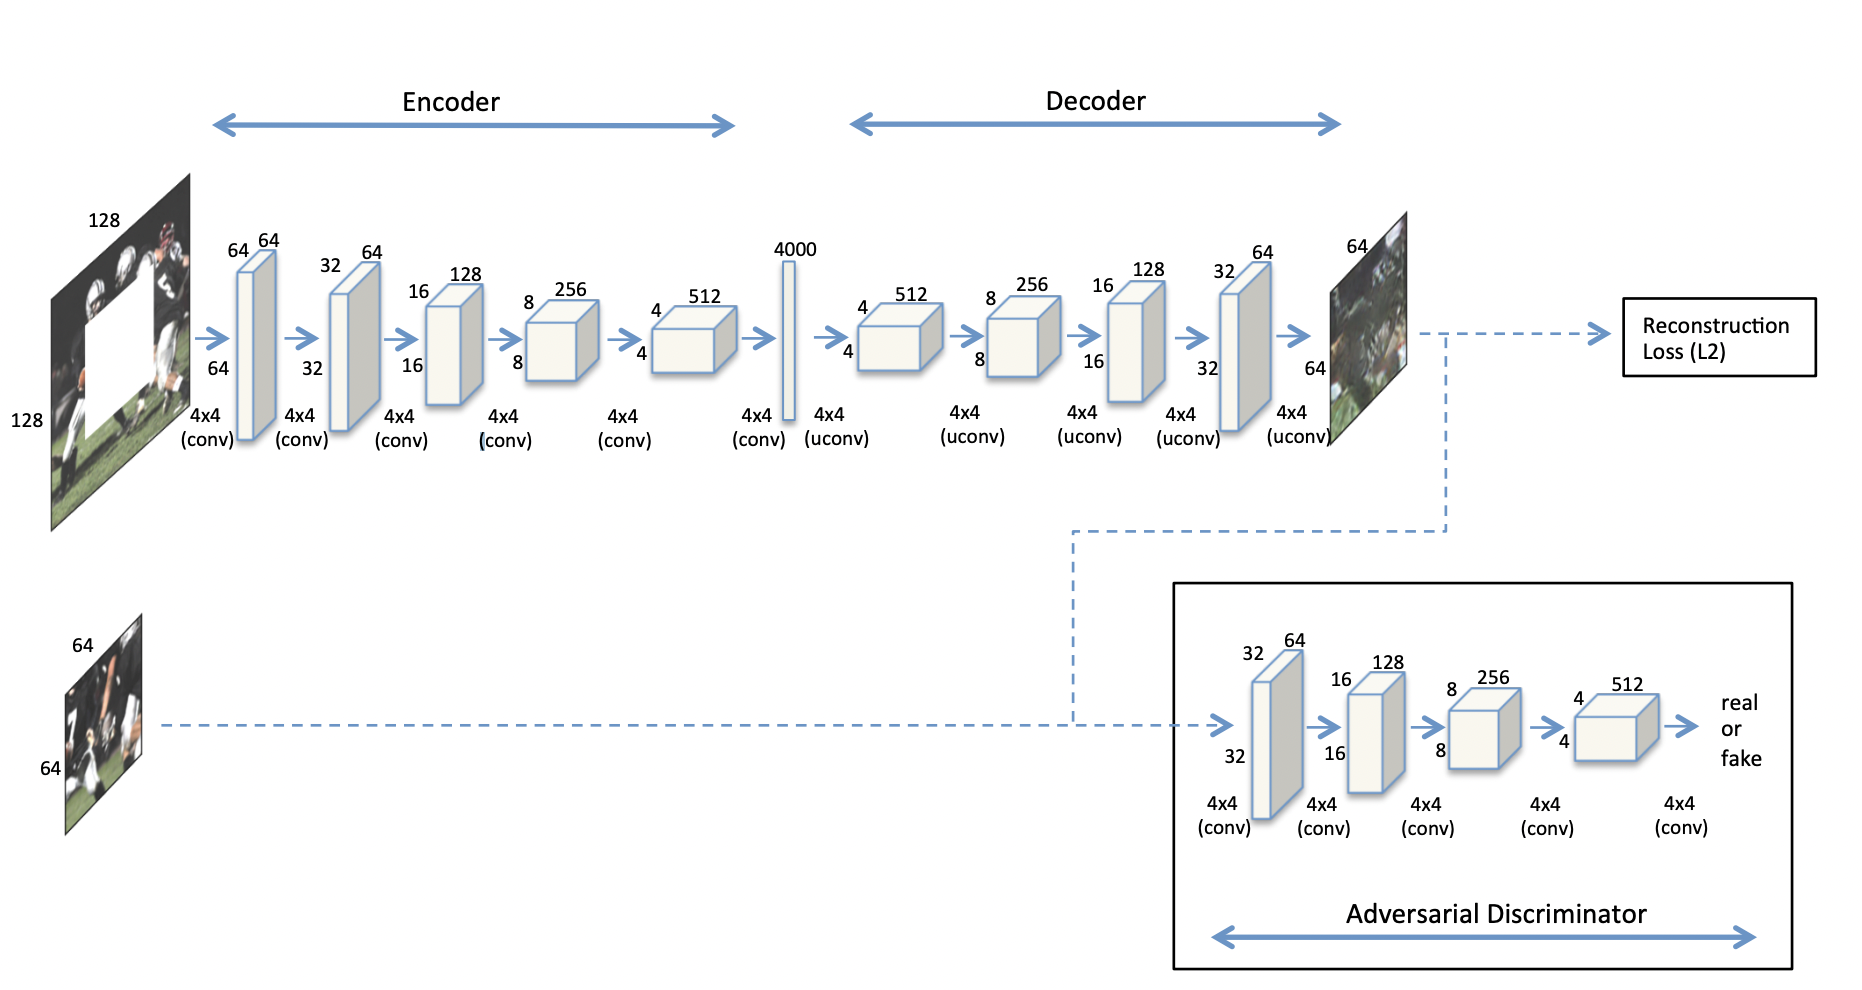

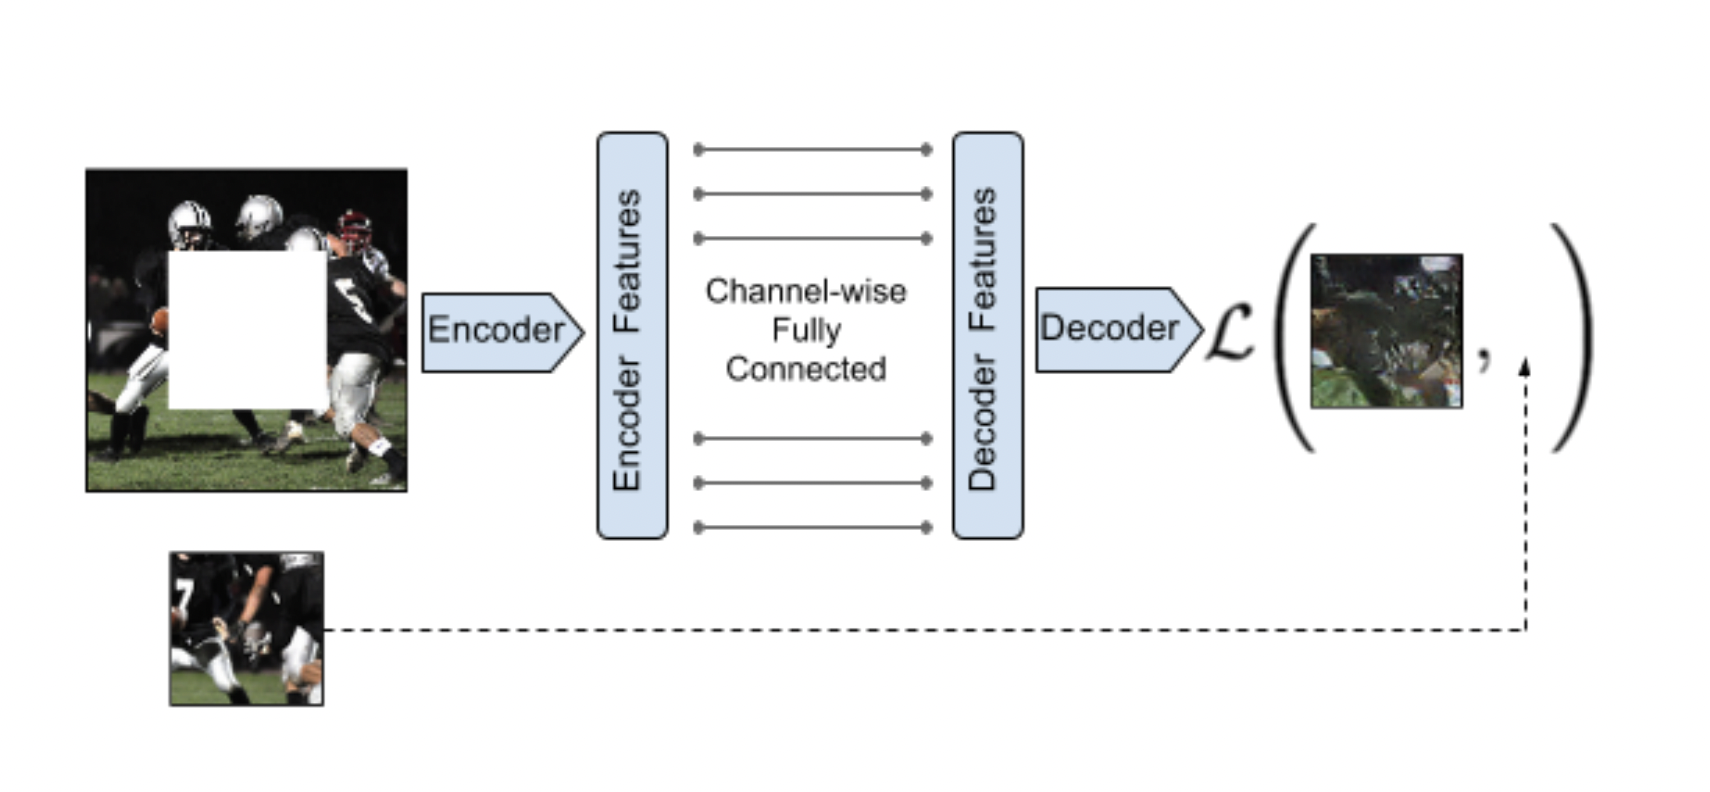

JOINT LOSS FUNCTION



In [25]:
class Generator(nn.Module):
    def __init__(self, channels=3):
        super(Generator, self).__init__()

        def downsample(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2))
            return layers

        def upsample(in_feat, out_feat, normalize=True):
            layers = [nn.ConvTranspose2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.ReLU())
            return layers

        self.model = nn.Sequential(
            *downsample(channels, 64, normalize=False),
            *downsample(64, 64),
            *downsample(64, 128),
            *downsample(128, 256),
            *downsample(256, 512),
            nn.Conv2d(512, 4000, 1),
            *upsample(4000, 512),
            *upsample(512, 256),
            *upsample(256, 128),
            *upsample(128, 64),
            nn.Conv2d(64, channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, stride, normalize):
            """Returns layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 3, stride, 1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = channels
        for out_filters, stride, normalize in [(64, 2, False), (128, 2, True), (256, 2, True), (512, 1, True)]:
            layers.extend(discriminator_block(in_filters, out_filters, stride, normalize))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, 3, 1, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

In [26]:
#Visulation function for 1 image 
def vis(idx):
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15,10)
    a = img[idx].cpu().detach().numpy()
    a = np.transpose(a, (1, 2, 0))
    ax[0].imshow(a)
    ax[0].set_title("The Original Image")
    ax[1].imshow(np.transpose(masked_imgs[idx], (1, 2, 0)))
    ax[1].set_title("The masked Image")
    ax[2].imshow(np.transpose(aux[idx], (1, 2, 0)))
    ax[2].set_title("Mask Image")

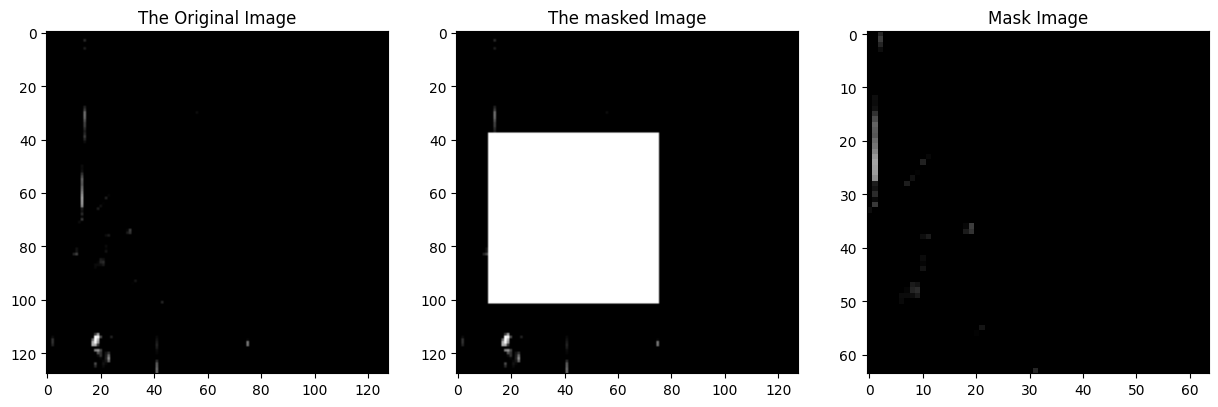

In [27]:
vis(0)

In [28]:
cuda = True if torch.cuda.is_available() else False
os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

#(PatchGAN)
patch_h, patch_w = int(mask_size / 2 ** 3), int(mask_size / 2 ** 3)
patch = (1, patch_h, patch_w)

In [29]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

def save_sample(batches_done):
    samples, masked_samples, i = next(iter(test_dataloader))
    samples = Variable(samples.type(Tensor))
    masked_samples = Variable(masked_samples.type(Tensor))
    i = i[0].item()  # Upper-left coordinate of mask
    # Generate inpainted image
    gen_mask = generator(masked_samples)
    filled_samples = masked_samples.clone()
    filled_samples[:, :, i : i + mask_size, i : i + mask_size] = gen_mask
    # Save sample
    sample = torch.cat((masked_samples.data, filled_samples.data, samples.data), -2)
    save_image(sample, "images/%d.png" % batches_done, nrow=6, normalize=True)

    
# Loss function
adversarial_loss = torch.nn.MSELoss()
pixelwise_loss = torch.nn.L1Loss()

# Initialize generator and discriminator
generator = Generator(channels=channels)

discriminator = Discriminator(channels=channels)

# Load pretrained models
if load_pretrained_models:
    generator.load_state_dict(torch.load("/kaggle/working/saved_models/generator.pth"))
    discriminator.load_state_dict(torch.load("/kaggle/working/saved_models/discriminator.pth")

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    pixelwise_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [30]:
print(generator)

Generator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2)
    (14): Conv2d(512, 4000, kernel_si

In [31]:
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


In [32]:
gen_adv_losses, gen_pixel_losses, disc_losses, counter = [], [], [], []

for epoch in range(n_epochs):
    
    ### Training ###
    gen_adv_loss, gen_pixel_loss, disc_loss = 0, 0, 0
    tqdm_bar = tqdm(dataloader, desc=f'Training Epoch {epoch} ', total=int(len(dataloader)))
    for i, (imgs, masked_imgs, masked_parts) in enumerate(tqdm_bar):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], *patch).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], *patch).fill_(0.0), requires_grad=False)

        # Configure input
        imgs = Variable(imgs.type(Tensor))
        masked_imgs = Variable(masked_imgs.type(Tensor))
        masked_parts = Variable(masked_parts.type(Tensor))

        
        ## Train Generator ##
        optimizer_G.zero_grad()

        # Generate a batch of images
        gen_parts = generator(masked_imgs)

        # Adversarial and pixelwise loss
        g_adv = adversarial_loss(discriminator(gen_parts), valid)
        g_pixel = pixelwise_loss(gen_parts, masked_parts)
        # Total loss
        g_loss = 0.001 * g_adv + 0.999 * g_pixel

        g_loss.backward()
        optimizer_G.step()

        ## Train Discriminator ##
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(masked_parts), valid)
        fake_loss = adversarial_loss(discriminator(gen_parts.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()
        
        gen_adv_loss, gen_pixel_loss, disc_loss
        gen_adv_losses, gen_pixel_losses, disc_losses, counter
        
        gen_adv_loss += g_adv.item()
        gen_pixel_loss += g_pixel.item()
        gen_adv_losses.append(g_adv.item())
        gen_pixel_losses.append(g_pixel.item())
        disc_loss += d_loss.item()
        disc_losses.append(d_loss.item())
        counter.append(i*batch_size + imgs.size(0) + epoch*len(dataloader.dataset))
        tqdm_bar.set_postfix(gen_adv_loss=gen_adv_loss/(i+1), gen_pixel_loss=gen_pixel_loss/(i+1), disc_loss=disc_loss/(i+1))
        
        # Generate sample at sample interval
        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            save_sample(batches_done)
            
    torch.save(generator.state_dict(), "/kaggle/working/saved_models/generator.pth")
    torch.save(discriminator.state_dict(), "/kaggle/working/saved_models/discriminator.pth")

Training Epoch 0 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 1 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 2 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 3 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 4 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 5 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 6 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 7 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 8 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 9 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 10 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 11 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 12 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 13 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 14 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 15 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 16 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 17 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 18 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 19 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 20 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 21 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 22 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 23 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 24 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 25 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 26 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 27 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 28 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 29 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 30 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 31 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 32 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 33 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 34 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 35 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 36 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 37 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 38 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 39 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 40 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 41 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 42 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 43 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 44 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 45 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 46 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 47 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 48 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 49 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 50 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 51 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 52 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 53 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 54 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 55 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 56 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 57 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 58 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 59 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 60 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 61 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 62 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 63 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 64 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 65 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 66 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 67 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 68 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 69 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 70 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 71 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 72 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 73 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 74 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 75 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 76 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 77 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 78 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 79 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 80 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 81 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 82 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 83 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 84 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 85 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 86 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 87 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 88 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 89 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 90 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 91 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 92 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 93 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 94 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 95 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 96 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 97 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 98 :   0%|          | 0/1119 [00:00<?, ?it/s]

Training Epoch 99 :   0%|          | 0/1119 [00:00<?, ?it/s]

In [33]:
!ls -al /kaggle/working/saved_models

total 163944
drwxr-xr-x 2 root root      4096 Dec 22 14:29 .
drwxr-xr-x 5 root root      4096 Dec 22 14:27 ..
-rw-r--r-- 1 root root   6226508 Dec 22 17:23 discriminator.pth
-rw-r--r-- 1 root root 161640224 Dec 22 17:23 generator.pth


In [34]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=counter, y=gen_pixel_losses, mode='lines', name='Gen Pixel Loss', marker_color='orange'))
fig.add_trace(go.Scatter(x=counter, y=disc_losses, mode='lines', name='Discriminator Loss', marker_color='seagreen'))
fig.show()

In [42]:
imgs, masked_imgs, aux = next(iter(test_dataloader))
g = generator(masked_imgs.type(Tensor))


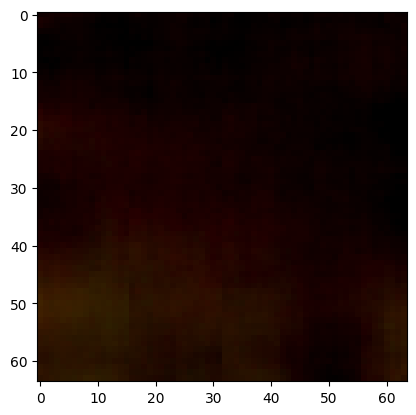

In [43]:
img_temp = g.cpu().detach().numpy()
img_temp = np.transpose(img_temp[0], (1, 2, 0))
plt.imshow(img_temp)

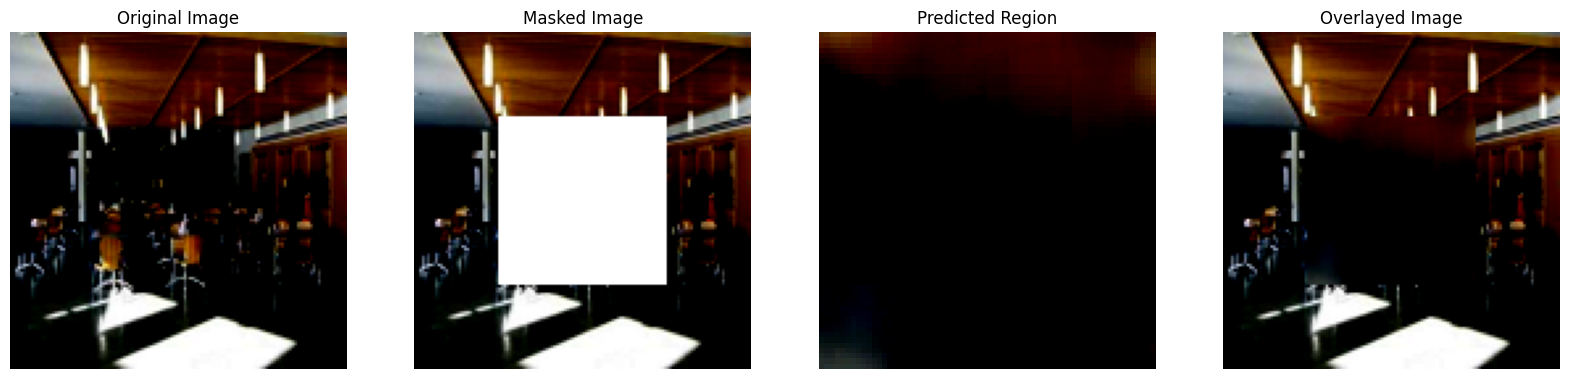

In [44]:
def vis(idx):
    fig, ax = plt.subplots(1, 4, figsize=(20, 10))

    # Original image
    original_image = imgs[idx].cpu().detach().numpy()
    original_image = np.transpose(original_image, (1, 2, 0))
    ax[0].imshow(original_image)
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    # Masked image
    masked_image = masked_imgs[idx].cpu().detach().numpy()
    masked_image = np.transpose(masked_image, (1, 2, 0))
    ax[1].imshow(masked_image)
    ax[1].set_title("Masked Image")
    ax[1].axis('off')

    # Predicted region
    predicted_mask = g[idx].cpu().detach().numpy()
    predicted_mask = np.transpose(predicted_mask, (1, 2, 0))
    ax[2].imshow(predicted_mask)
    ax[2].set_title("Predicted Region")
    ax[2].axis('off')

    # Overlay predicted region onto the masked image
    overlay_image = masked_image.copy()
    i = (img_size - mask_size) // 2  # Center mask calculation
    overlay_image[i:i + mask_size, i:i + mask_size, :] = predicted_mask
    ax[3].imshow(overlay_image)
    ax[3].set_title("Overlayed Image")
    ax[3].axis('off')

    plt.show()


# Visualize results for a specific index
vis(1)

In [45]:
adv_losses, gen_pixel_losses, disc_losses, counter = [], [], [], []
generator.load_state_dict(torch.load("/kaggle/working/saved_models/generator.pth"))
discriminator.load_state_dict(torch.load("/kaggle/working/saved_models/discriminator.pth"))

generator.eval()
discriminator.eval()   




    ### Testing ###
gen_adv_loss, gen_pixel_loss, disc_loss = 0, 0, 0
tqdm_bar = tqdm(test_dataloader, desc=f'Testing' , total=int(len(test_dataloader)))
for i, (imgs, masked_imgs, mp) in enumerate(tqdm_bar):

    mp=mp[0].item();
    
    #print(imgs.shape, masked_imgs.shape, masked_parts.shape)
    # Adversarial ground truths
    valid = Variable(Tensor(imgs.shape[0], *patch).fill_(1.0), requires_grad=False)
    fake = Variable(Tensor(imgs.shape[0], *patch).fill_(0.0), requires_grad=False)

    # Configure input
    imgs = Variable(imgs.type(Tensor))
    masked_imgs = Variable(masked_imgs.type(Tensor))


    # Generate a batch of images
    gen_parts = generator(masked_imgs)
    masked_parts = masked_imgs[:, :, mp : mp + mask_size, mp : mp + mask_size]
    #masked_parts[:, :, mp : mp + mask_size, mp : mp + mask_size] = gen_parts

    
    #print(f"gen_parts shape: {gen_parts.shape}")
    #print(f"masked_parts shape: {masked_parts.shape}")


    # Adversarial and pixelwise loss
    g_adv = adversarial_loss(discriminator(gen_parts), valid)
    g_pixel = pixelwise_loss(gen_parts, masked_parts)
    # Total loss
    g_loss = 0.001 * g_adv + 0.999 * g_pixel

    
    # Measure discriminator's ability to classify real from generated samples
    real_loss = adversarial_loss(discriminator(masked_parts), valid)
    fake_loss = adversarial_loss(discriminator(gen_parts.detach()), fake)
    d_loss = 0.5 * (real_loss + fake_loss)

        
    gen_adv_loss, gen_pixel_loss, disc_loss
    gen_adv_losses, gen_pixel_losses, disc_losses, counter
    
    gen_adv_loss += g_adv.item()
    gen_pixel_loss += g_pixel.item()
    gen_adv_losses.append(g_adv.item())
    gen_pixel_losses.append(g_pixel.item())
    disc_loss += d_loss.item()
    disc_losses.append(d_loss.item())
    counter.append(i*12 + imgs.size(0) + len(test_dataloader.dataset))
    tqdm_bar.set_postfix(gen_adv_loss=gen_adv_loss/(i+1), gen_pixel_loss=gen_pixel_loss/(i+1), disc_loss=disc_loss/(i+1))
    
    # Generate sample at sample interval
    batches_done =  len(test_dataloader) + i
    if batches_done % sample_interval == 0:
        save_sample(batches_done)
        


Testing:   0%|          | 0/334 [00:00<?, ?it/s]

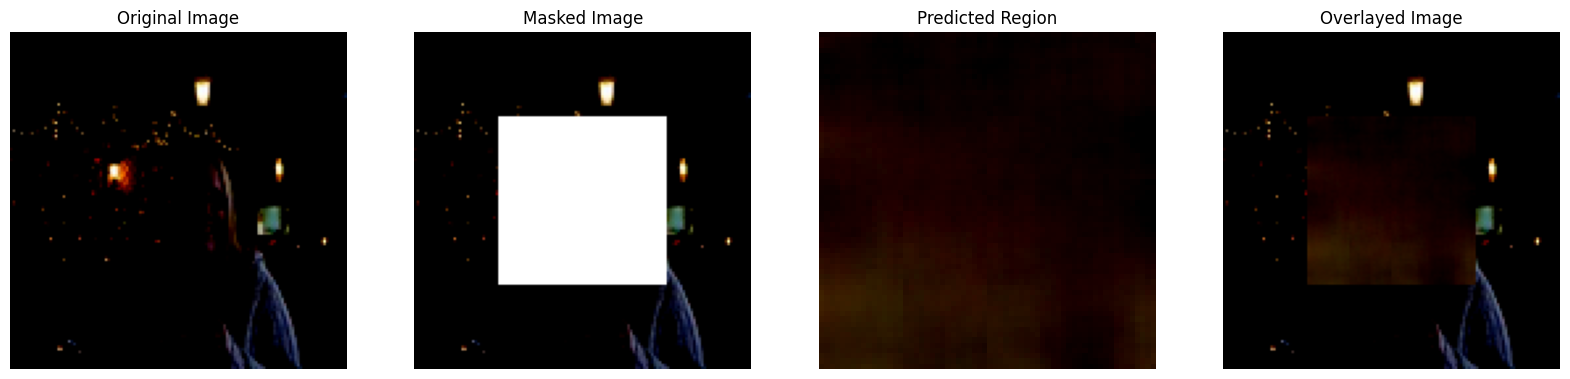

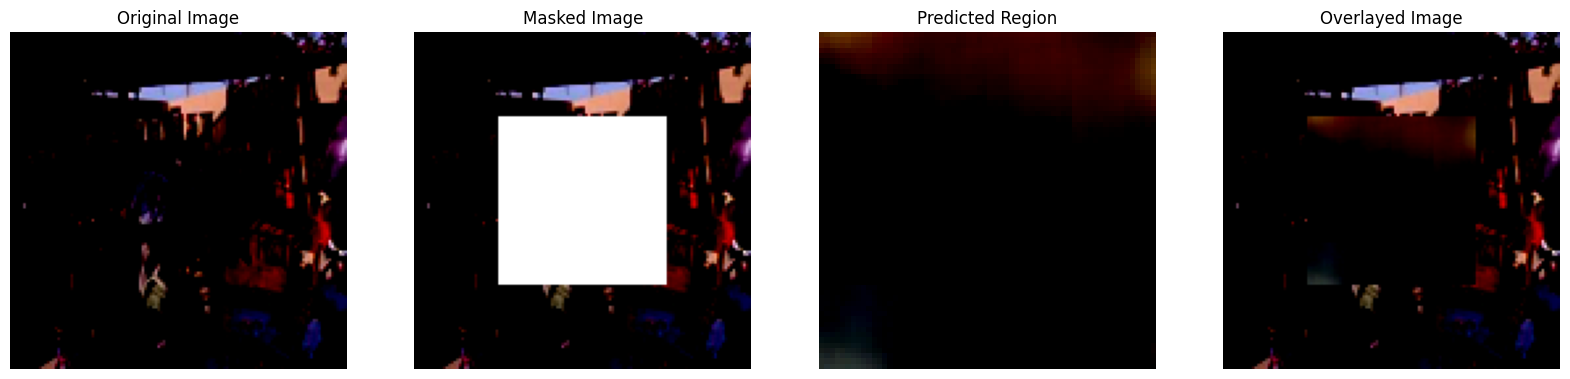

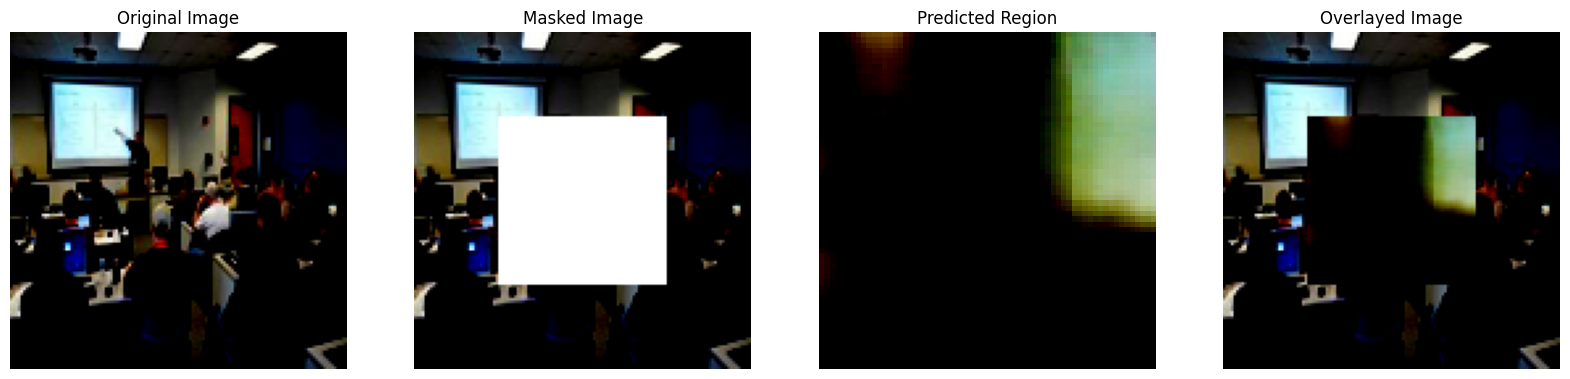

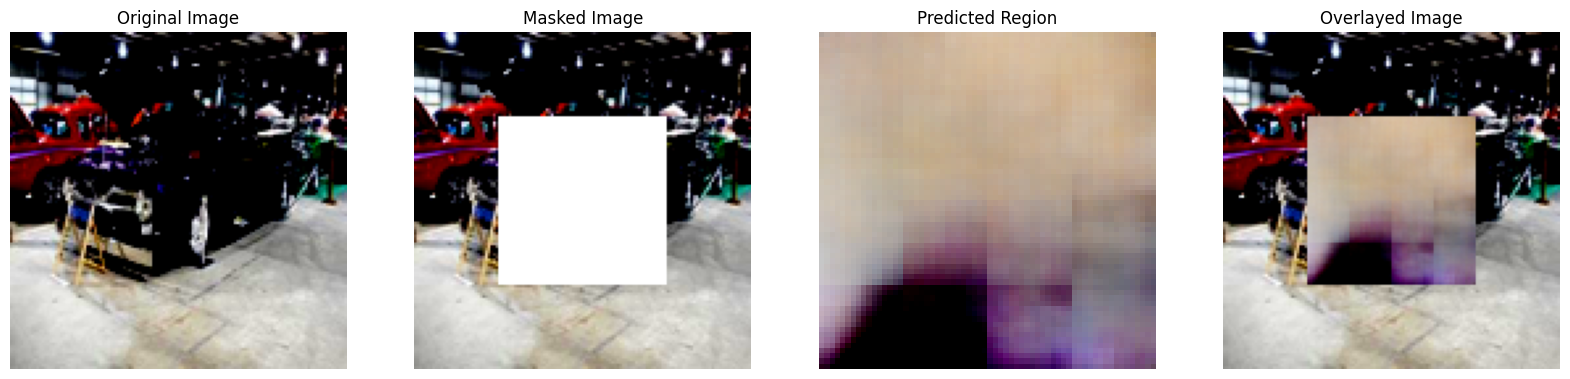

In [49]:
for i in range(0,4):
    vis(i)